## Aggregates models & data to county / fip level

### Packages

In [63]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import xagg as xa
import dask
import matplotlib.pyplot as plt

### Inputs

In [64]:
filein = "/storage/group/pches/default/users/dcl5300/wbm_soilM_uc_2024_DATA/projections/eCONUS/out/LOCA2/GFDL-ESM4_r1i1p1f1_ssp245_SMAP_mse.nc"
county_shp_path = "/storage/work/cta5244/avila_et_al_2026_pyWBM_yield/shape_files/counties_contig_plot.shp"
ds = xr.open_dataset(filein, chunks='auto')

### Lower nc file size

In [65]:
lon_max = -80
lon_min = -90
lat_min = 34
lat_max = 45

ds = ds.where((ds.lon >= lon_min) & (ds.lon <= lon_max) & (ds.lat >= lat_min) & (ds.lat <= lat_max))
ds = ds.sel(time=slice(f'{2060}-06-01', f'{2060}-10-31'))
ds.load()

<xarray.Dataset> Size: 38MB
Dimensions:    (time: 153, lat: 194, lon: 317)
Coordinates:
  * lon        (lon) float32 1kB -106.6 -106.4 -106.3 ... -67.31 -67.19 -67.06
  * lat        (lat) float32 776B 25.19 25.31 25.44 25.56 ... 49.06 49.19 49.31
  * time       (time) object 1kB 2060-06-01 00:00:00 ... 2060-10-31 00:00:00
Data variables:
    soilMoist  (time, lat, lon) float32 38MB nan nan nan nan ... nan nan nan nan

### Aggregation

In [66]:
us_county = gpd.read_file(county_shp_path)
us_county = us_county.to_crs("EPSG:4326")

# Area weight and aggregate
weightmap = xa.pixel_overlaps(ds, us_county)
aggregated = xa.aggregate(ds, weightmap)

# Convert to pandas
ds_out = aggregated.to_dataset().to_dataframe()
ds_out = ds_out.reset_index().set_index(['fips','time'])

creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating soilMoist...
all variables aggregated to polygons!


#### Some exploratory plotting

In [67]:
fips_mean = ds_out.groupby(level=['fips']).mean()

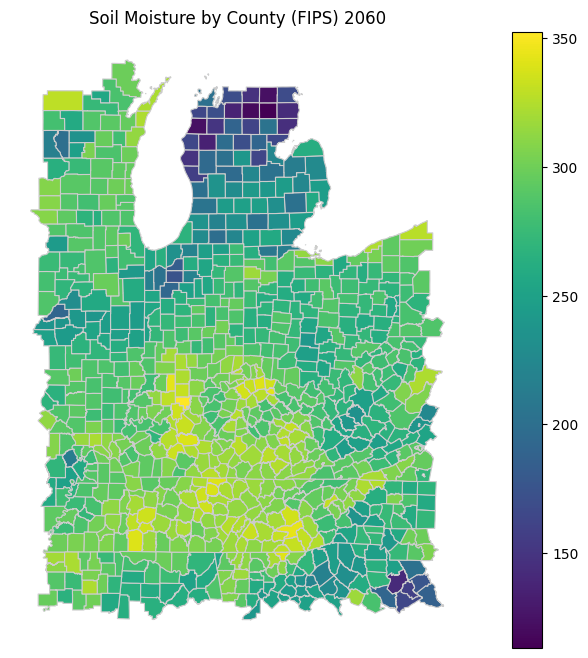

In [62]:
merged_gdf = us_county.merge(fips_mean, on='fips')
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged_gdf.plot(column='soilMoist', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title("Soil Moisture by County (FIPS) 2060 MOSAIC")
ax.set_axis_off()

# Show the plot
plt.show()

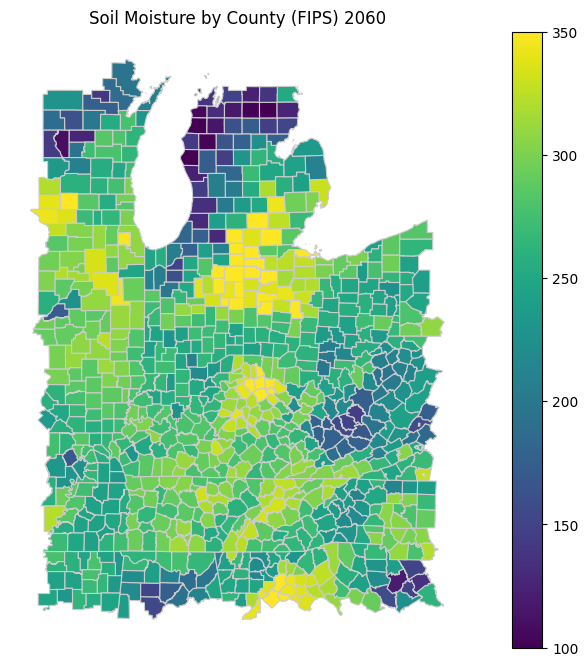

In [69]:
merged_gdf = us_county.merge(fips_mean, on='fips')
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged_gdf.plot(column='soilMoist', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, vmax=350, vmin=100)
ax.set_title("Soil Moisture by County (FIPS) 2060 SMAP")
ax.set_axis_off()

# Show the plot
plt.show()

### 